## NRMS Model with Title Word Embedding
### Course: *02456 - Deep Learning*  
**Technical University of Denmark (DTU)**  

---

### 📜 **Context**  
- The below script has been created in relation to the course 02456 - Deep Learning at the Technical University of Denmark. We were tasked with building a news recommender model that could the Danish media Extra Bladet predict user preferences for news articles. We implemented our own pytorch model, that is inspired from the article [Neural News Recommendation with Multi-Head Self-Attention](https://dl.acm.org/doi/10.1145/3640457.3687164)
---

### 📝 **Differences from the Original Paper**  
- **Original Implementation**: The paper embeds words from the **title** of each article.  
- **Our Implementation**: This model is a replication of the original model using words in the title to represent each article. The model has been implemented in Pytorch. We use 20 attention heads with a dimension of 20, whereas the paper uses 16 x 16. We have also implemented a more advanced pytorch model that uses a full article embedding rather than just the title (see the other notebook).
---

### 🛠️ **What Does This Script Do?**  

1. **Model Creation**:  
   - Implements a PyTorch version of the **NRMS model** based on **multi-head self-attention**.

2. **Training**:  
   - Trains the model using training data from **Extra Bladet's "2024 RecSys Challenge"**.

3. **Evaluation**:  
   - Scores the model on the **full test set**, which contains more than **13,000,000 user visits** to the Extra Bladet website.

---

### 💻 **Hardware Setup**  

- During our project, we have been running this notebook on DTU's HPC and on Google Colab Pro on the T4 GPU with 50GB of system RAM.
---
### 🔗 **References**  

1. Article: [Neural News Recommendation with Multi-Head Self-Attention](https://dl.acm.org/doi/10.1145/3640457.3687164)  
2. Dataset: [Extra Bladet's "2024 RecSys Challenge"](https://recsys.eb.dk/)

# Installing Correct Package Versions
Some of the legacy code we were given by Johannes, requires packages not pre-installed on colab or a specific package version. We download these below.

In [ ]:
!pip install polars==0.20.8
!pip install torchmetrics

# Setting the Correct File Paths
Below we set the file paths for where we store our data and python files. If you want to run it yourself, please change these paths.

In [ ]:
# Change these to your paths (These are setup to run on google colab)
drive_path = '/content/drive/'
python_files_path = '/content/drive/MyDrive/DeepLearningProject'
article_embeddings_path = '/content/drive/MyDrive/DeepLearningProject/Data/ebnerd_small/articles.parquet'
user_impressions_path = '/content/drive/MyDrive/DeepLearningProject/Data'

### 💻 Setting Up the Notebook for Google Colab  

To ensure compatibility and seamless execution, the notebook is configured to run on **Google Colab**. This setup includes installing necessary dependencies, mounting Google Drive for accessing datasets and saving results.

In [ ]:
from google.colab import drive
import sys
import torch

# Mount Google Drive
drive.mount(drive_path)

# Adjust path to where we store our files
sys.path.append(python_files_path)

# Set the device to CUDA if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Importing Needed Packages and Our Own Implementation of the Model and Data Loaders

In [ ]:
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
import matplotlib.pyplot as plt
import datetime as dt
import polars as pl
import numpy as np
import shutil
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAUROC
from torch.optim.lr_scheduler import ReduceLROnPlateau

from ebrec.utils._constants import *

from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_prediction_scores,
    truncate_history,
    ebnerd_from_path,
)

from ebrec.evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore
from ebrec.utils._articles import convert_text2encoding_with_transformers
from ebrec.utils._polars import concat_str_columns, slice_join_dataframes, split_df_chunks, concat_str_columns
from ebrec.utils._articles import create_article_id_to_value_mapping
from ebrec.utils._nlp import get_transformers_word_embeddings
from ebrec.utils._python import write_submission_file, rank_predictions_by_score, write_json_file

from ebrec.models.newsrec.nrms_baseline_pytorch import NewsEncoder, UserEncoder, NRMS_baseline_pytorch, ScorerModel
from ebrec.models.newsrec.dataloader_pytorch import NRMSDataLoaderPretransform, nrms_custom_collate_fn
from ebrec.models.newsrec.model_config import hparams_nrms

# Load Prespecified Paramaters for Our Model and the Training Procedure

In [ ]:
DATASPLIT = hparams_nrms.data_split
HISTORY_SIZE = hparams_nrms.history_size
MAX_TITLE_LENGTH = hparams_nrms.title_size
TRAIN_FRACTION = hparams_nrms.train_fraction
FRACTION_TEST = hparams_nrms.test_fraction
SEED = hparams_nrms.seed
NPRATIO = hparams_nrms.np_ratio
TRAIN_BATCH_SIZE = hparams_nrms.train_batch_size
TEST_BATCH_SIZE = hparams_nrms.test_batch_size
NUM_CLASSES = hparams_nrms.num_classes
NUM_EPOCH = hparams_nrms.num_epoch
PATIENCE = hparams_nrms.patience_counter
VAL_INTERVAL = hparams_nrms.val_interval

# Load the Articles

In [ ]:
# Set path for where the articles are stored and load them into a dataframe
df_articles = pl.read_parquet(Path(article_embeddings_path).expanduser())

# Prespecify what columns from the dataset we are interested in
COLUMNS = [
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_USER_COL,
]

# Load the User-Impressions and Create Our Training and Validation Dataset

In [ ]:
# Expand the user-impressions path to an absolute path
PATH = Path(user_impressions_path).expanduser()

# Create a single DataFrame `df` by concatenating processed training and validation datasets
df = (
    pl.concat(
        [
            # Load and process the training data using a custom function `ebnerd_from_path`
            ebnerd_from_path(
                PATH.joinpath(DATASPLIT, "train"),  # Path to training data
                history_size=HISTORY_SIZE,         # Number of historical interactions to consider
                padding=0,                         # Padding value for shorter histories
            ),
            # Load and process the validation data using the same function
            ebnerd_from_path(
                PATH.joinpath(DATASPLIT, "validation"),  # Path to validation data
                history_size=HISTORY_SIZE,              # Number of historical interactions to consider
                padding=0,                              # Padding value for shorter histories
            ),
        ]
    )
    # Randomly sample a fraction of the combined data for training, with a fixed seed for reproducibility
    .sample(fraction=TRAIN_FRACTION, shuffle=True, seed=SEED)
    # Select specific columns of interest for the model input
    .select(COLUMNS)
    # Apply the sampling strategy (e.g., negative sampling) to create balanced data
    .pipe(
        sampling_strategy_wu2019,  # Sampling strategy based on Wu et al. (2019)
        npratio=NPRATIO,          # Ratio of negative to positive samples
        shuffle=True,             # Shuffle the data after sampling
        with_replacement=True,    # Allow sampling with replacement
        seed=SEED,                # Seed for reproducibility
    )
    # Add a binary labels column (e.g., click or no-click)
    .pipe(create_binary_labels_column)
)

# Define the last day in the dataset as the validation cutoff
last_dt = df[DEFAULT_IMPRESSION_TIMESTAMP_COL].dt.date().max() - dt.timedelta(days=1)

# Split the data into training and validation sets based on the cutoff
df_train = df.filter(pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL).dt.date() < last_dt)  # Training set
df_validation = df.filter(pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL).dt.date() >= last_dt)  # Validation set


## Init model using HuggingFace's tokenizer and wordembedding
In the original implementation, they use the GloVe embeddings and tokenizer. To get going fast, we'll use a multilingual LLM from Hugging Face.
Utilizing the tokenizer to tokenize the articles and the word-embedding to init NRMS.

In [ ]:
TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = [DEFAULT_SUBTITLE_COL, DEFAULT_TITLE_COL]

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)

word2vec_embedding = torch.tensor(word2vec_embedding, dtype=torch.float, device=device)
#
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Initialize the DataLoader for the training dataset
train_dataset = NRMSDataLoaderPretransform(
    behaviors=df_train,                      # The training dataset containing user behaviors
    article_dict=article_mapping,            # A dictionary mapping article IDs to their embeddings or representations
    unknown_representation="zeros",          # Use zero vectors for unknown articles in the user history
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,  # Column name containing the user’s article history
    eval=False,                              # Set to False for training mode
)

# Initialize the DataLoader for the validation dataset
val_dataset = NRMSDataLoaderPretransform(
    behaviors=df_validation,                 # The validation dataset containing user behaviors
    article_dict=article_mapping,            # Use the same article mapping as for training
    unknown_representation="zeros",          # Use zero vectors for unknown articles in the user history
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,  # Column name containing the user’s article history
    eval=False,                              # Set to False since we’re not evaluating here yet
)

# Create a PyTorch DataLoader for the training dataset
data_loader_train_pt = DataLoader(
    train_dataset,                           # The processed training dataset
    batch_size=TRAIN_BATCH_SIZE,             # Batch size for training
    shuffle=True                             # Shuffle the data for randomized training batches
)

# Create a PyTorch DataLoader for the validation dataset
data_loader_val_pt = DataLoader(
    val_dataset,                             # The processed validation dataset
    batch_size=TRAIN_BATCH_SIZE,             # Batch size for validation
    shuffle=True                             # Shuffle the validation data for consistency with training
)

# Training the Model

## Setting up Training Parameters and Model Performance Metrics

In [ ]:
# Define the model and move it to cuda if available
model = NRMS_baseline_pytorch(hparams_nrms, word2vec_embedding, seed = 1)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), hparams_nrms.learning_rate)

MODEL_NAME = model.__class__.__name__

In [ ]:
# Initialize AUC metrics
train_auc_metric = MulticlassAUROC(num_classes=NUM_CLASSES, average="macro").to(device)
val_auc_metric = MulticlassAUROC(num_classes=NUM_CLASSES, average="macro").to(device)
best_val_auc = float('-inf')  # For maximizing AUC

# Set up parameters for early stopping
patience_counter = 0

# Store best model
best_model_weights = None

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.2, min_lr = 1e-6, verbose=True)

# Initialize lists for logging
train_loss_intervals = []  # Training loss after each validation interval
valid_loss_intervals = []  # Validation loss after each validation interval
train_auc_intervals = []   # Training AUC after each validation interval
valid_auc_intervals = []   # Validation AUC after each validation interval
interval_counts = []       # Track intervals (for plotting x-axis)

## Training loop

In [ ]:
model.train()  # Ensure the model is in training mode
batch_counter = 0 # Set batch counter to 0.

for epoch in range(NUM_EPOCH):
    print(f"Epoch {epoch + 1}/{NUM_EPOCH}")
    epoch_train_loss = 0 # Set training loss for each epoch to 0 at the start
    train_auc_metric.reset() # Reset AUC computations

    # Training loop
    model.train()  # Switch to training mode
    for batch_idx, arguments in enumerate(data_loader_train_pt): # Loop over training batches
        targets = arguments[1].to(device)
        his_input = arguments[0][0].to(device)
        pred_input = arguments[0][1].to(device)

        optimizer.zero_grad() # Reset gradients

        predictions = model(his_input, pred_input)  # Forward pass

        loss = criterion(predictions, targets.argmax(dim=1))  # Compute loss
        epoch_train_loss += loss.detach().item() # Add loss to overall epoch loss

        # Update training AUC metric
        train_auc_metric.update(predictions, targets.argmax(dim=1))

        loss.backward() # Compute the gradients of the loss function with respect to the model parameters
        optimizer.step() # Update the model parameters using the gradients computed

        batch_counter += 1 # Increment counter

        """
        After we have trained on VAL_INTERVAL BATCHES we evaluate the model on the validation set. We do this because we saw
        that the model overfitted when we did early stopping on the epoch level, when training on all the training data.
        """
        if batch_counter % VAL_INTERVAL == 0:
            model.eval()  # Switch to evaluation mode
            val_loss_total = 0
            val_auc_metric.reset()

            # Compute the predictions on the validation set
            with torch.no_grad():
                for val_arguments in data_loader_val_pt:
                    val_targets = val_arguments[1].to(device)
                    val_his_input = val_arguments[0][0].to(device)
                    val_pred_input = val_arguments[0][1].to(device)

                    val_preds = model(val_his_input, val_pred_input) # Predict based on the input
                    val_loss = criterion(val_preds, val_targets.argmax(dim=1)) # Compute the validation loss
                    val_loss_total += val_loss.detach().item() # Add to the total loss

                    # Update validation AUC metric
                    val_auc_metric.update(val_preds, val_targets.argmax(dim=1))

            # Average validation loss
            avg_val_loss = val_loss_total / len(data_loader_val_pt)

            # Calculate validation AUC
            val_auc = val_auc_metric.compute().item()

            # Log metrics
            train_loss_intervals.append(epoch_train_loss / batch_counter)  # Avg training loss so far
            valid_loss_intervals.append(avg_val_loss)
            train_auc_intervals.append(train_auc_metric.compute().item())
            valid_auc_intervals.append(val_auc)
            interval_counts.append(batch_counter)

            # Print the performance of the model on the training (trained on so far) and the validation set
            print(f"Batch {batch_counter}: Train Loss: {train_loss_intervals[-1]:.4f}, Train AUC: {train_auc_intervals[-1]:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation AUC: {val_auc:.4f}")

            # Step the scheduler with validation AUC
            scheduler.step(val_auc)

            # Early Stopping Check (based on AUC on the validation set)
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                patience_counter = 0
                best_model_weights = model.state_dict()  # Save best model weights
            else:
                patience_counter += 1

            # If model has not improved for PATIENCE * VAL_INTERVAL batches of training, stop training and load the model that performed best on the validation set.
            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered after {batch_counter} batches (within epoch).")
                model.load_state_dict(best_model_weights)  # Restore best weights
                break

            model.train()  # Switch back to training mode

    # Break the epoch loop if early stopping triggered
    if patience_counter >= PATIENCE:
        break

# Save the best model weights (if early stopping occurred)
if best_model_weights:
    model.load_state_dict(best_model_weights)

# Save the best encoders to use for the scoring model on the test set
torch.save(model.news_encoder.state_dict(), "newsencoder.pth")
torch.save(model.user_encoder.state_dict(), "userencoder.pth")

Epoch 1/5
Batch 100: Train Loss: 1.6037, Train AUC: 0.5439, Validation Loss: 1.6002, Validation AUC: 0.5568
Batch 200: Train Loss: 1.5983, Train AUC: 0.5549, Validation Loss: 1.5990, Validation AUC: 0.5507
Batch 300: Train Loss: 1.5920, Train AUC: 0.5688, Validation Loss: 1.6007, Validation AUC: 0.5482
Batch 400: Train Loss: 1.5859, Train AUC: 0.5793, Validation Loss: 1.5908, Validation AUC: 0.5728
Batch 500: Train Loss: 1.5820, Train AUC: 0.5843, Validation Loss: 1.5886, Validation AUC: 0.5784
Batch 600: Train Loss: 1.5771, Train AUC: 0.5921, Validation Loss: 1.5802, Validation AUC: 0.5911
Batch 700: Train Loss: 1.5743, Train AUC: 0.5964, Validation Loss: 1.5845, Validation AUC: 0.5868
Batch 800: Train Loss: 1.5717, Train AUC: 0.6004, Validation Loss: 1.5828, Validation AUC: 0.5879
Batch 900: Train Loss: 1.5705, Train AUC: 0.6024, Validation Loss: 1.5868, Validation AUC: 0.5854
Batch 1000: Train Loss: 1.5688, Train AUC: 0.6050, Validation Loss: 1.5811, Validation AUC: 0.5909
Batch 110

# Plotting the Model Performance Under Training Procedure

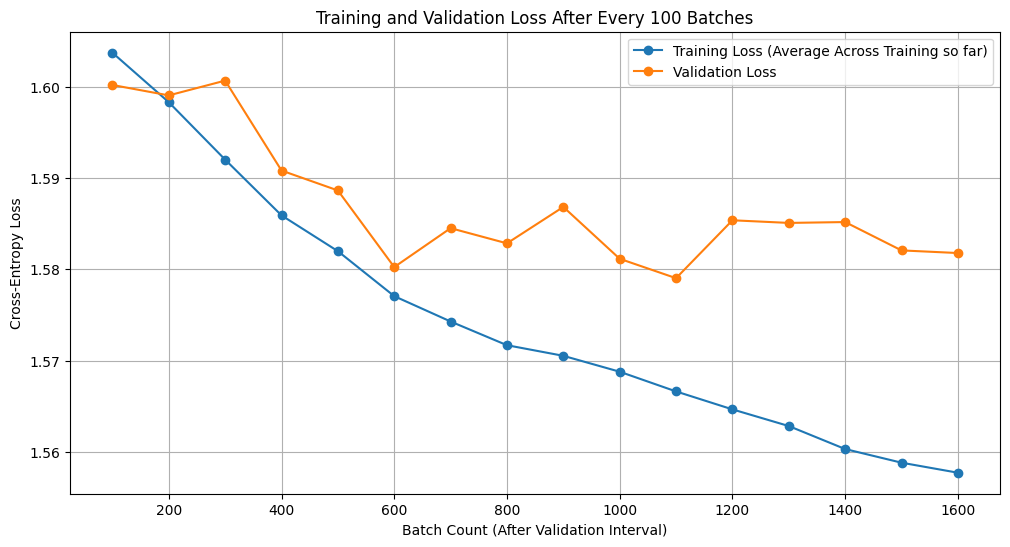

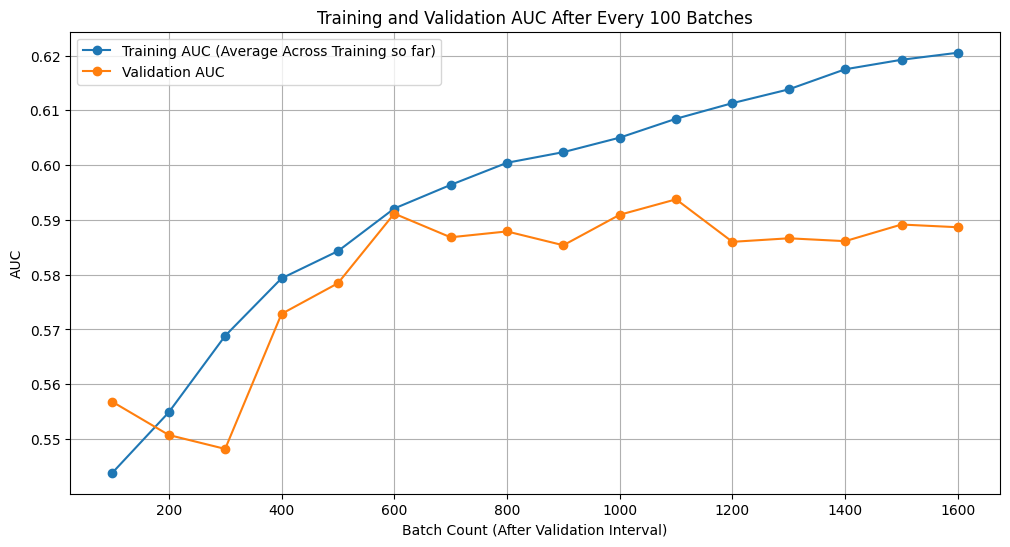

In [ ]:
# Plot training and validation metrics for each interval
# Plot 1: Loss (Training and Validation)
plt.figure(figsize=(12, 6))
plt.plot(interval_counts, train_loss_intervals, label="Training Loss (Average Across Training so far)", marker='o')
plt.plot(interval_counts, valid_loss_intervals, label="Validation Loss", marker='o')

plt.xlabel("Batch Count (After Validation Interval)")
plt.ylabel("Cross-Entropy Loss")
plt.title(f"Training and Validation Loss After Every {VAL_INTERVAL} Batches")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: AUC (Training and Validation)
plt.figure(figsize=(12, 6))
plt.plot(interval_counts, train_auc_intervals, label="Training AUC (Average Across Training so far)", marker='o')
plt.plot(interval_counts, valid_auc_intervals, label="Validation AUC", marker='o')

plt.xlabel("Batch Count (After Validation Interval)")
plt.ylabel("AUC")
plt.title(f"Training and Validation AUC After Every {VAL_INTERVAL} Batches")
plt.legend()
plt.grid(True)
plt.show()

# We Now Let the Final Model Score on the Large Test Set

In [ ]:
# We create an instance of a news_encoder and a user_encoder
news_encoder = NewsEncoder(word2vec_embedding, hparams_nrms.title_size, hparams_nrms.dropout, hparams_nrms.head_num, hparams_nrms.head_dim, hparams_nrms.word_embedding_dim, hparams_nrms.attention_hidden_dim, hparams_nrms.seed).to(device)
user_encoder = UserEncoder(news_encoder, hparams_nrms.head_num, hparams_nrms.head_dim, hparams_nrms.attention_hidden_dim, 1).to(device)

# Load the best performing model from the training
news_encoder.load_state_dict(torch.load("newsencoder.pth"))
user_encoder.load_state_dict(torch.load("userencoder.pth"))

<ipython-input-14-3d9f440391e1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  news_encoder.load_state_dict(torch.load("newsencoder.pth"))
<ipython-input-14-3d9f440391e1>:

<All keys matched successfully>

In [ ]:
scorer_model = ScorerModel(user_encoder, news_encoder) # Intialize the model

# Load the Test Set

In [ ]:
print("Initiating testset...")
df_test = (
    ebnerd_from_path(
        PATH.joinpath(DATASPLIT, "test"),
        history_size=HISTORY_SIZE,
        padding=0,
    )
    .sample(fraction=FRACTION_TEST)
    .with_columns(
        pl.col(DEFAULT_INVIEW_ARTICLES_COL)
        .list.first()
        .alias(DEFAULT_CLICKED_ARTICLES_COL)
    )
    .select(COLUMNS + [DEFAULT_IS_BEYOND_ACCURACY_COL])
    .with_columns(
        pl.col(DEFAULT_INVIEW_ARTICLES_COL)
        .list.eval(pl.element() * 0)
        .alias(DEFAULT_LABELS_COL)
    )
)

Initiating testset...


# Split the Test Set

In [ ]:
# Split test in beyond-accuracy TRUE / FALSE. In the BA 'article_ids_inview' is 250.
df_test_wo_beyond = df_test.filter(~pl.col(DEFAULT_IS_BEYOND_ACCURACY_COL))
df_test_w_beyond = df_test.filter(pl.col(DEFAULT_IS_BEYOND_ACCURACY_COL))

# Chunk the Test Set so it can Fit into Memory

In [ ]:
# Evaluating the test test can be memory intensive, we'll chunk it up:
TEST_CHUNKS_DIR = PATH.joinpath("test_chunks")
TEST_CHUNKS_DIR.mkdir(parents=True, exist_ok=True)

N_CHUNKS_TEST = 10

df_test_chunks = split_df_chunks(df_test_wo_beyond, n_chunks=N_CHUNKS_TEST)
df_pred_test_wo_beyond = []

# Run the Model on the Test Set Without Beyond-Accuracy

In [ ]:
# Start processing test data chunks for predictions
CHUNKS_DONE = 0  # Tracks the number of chunks already processed
print("Initiating test set processing without beyond-accuracy metrics...")

# Iterate through each test data chunk that hasn't been processed yet
for i, df_test_chunk in enumerate(df_test_chunks[CHUNKS_DONE:], start=1 + CHUNKS_DONE):
    print(f"Now Processing chunk number: {i}")

    # Create the DataLoader for the current test chunk
    test_dataset = NRMSDataLoaderPretransform(
        behaviors=df_test_chunk,                    # Test chunk containing user behaviors
        article_dict=article_mapping,               # Dictionary mapping article IDs to embeddings
        unknown_representation="zeros",             # Unknown articles are represented as zero vectors
        history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,  # Column containing user history
        eval=True                                   # Set to evaluation mode
    )
    test_dataloader_wo_b = DataLoader(
        test_dataset,                               # The preprocessed test dataset
        batch_size=TEST_BATCH_SIZE,                # Batch size for test predictions
        shuffle=False,                              # No shuffling required for evaluation
        collate_fn=nrms_custom_collate_fn          # Custom collate function for batching
    )

    # Set the model to evaluation mode to disable training-specific layers like Dropout
    model.eval()
    predictions_test = []  # List to store predictions for this chunk

    # Compute predictions without gradient calculations for efficiency
    with torch.no_grad():
        for arguments in test_dataloader_wo_b:
            targets = arguments[1].to(device)       # Targets (e.g., labels) moved to the device
            his_input = arguments[0][0].to(device) # Historical input for the user
            pred_input = arguments[0][1].to(device) # Candidate news articles for scoring

            predictions = scorer_model(his_input, pred_input)  # Generate predictions
            predictions_test.extend(predictions.tolist())      # Collect predictions as a Python list

    # Add prediction scores to the DataFrame and rank them
    df_test_chunk = add_prediction_scores(df_test_chunk, predictions_test).with_columns(
        pl.col("scores")
        .map_elements(lambda x: list(rank_predictions_by_score(x)))  # Rank predictions by score
        .alias("ranked_scores")                                     # Create a new column for ranked scores
    )

    # Save the processed chunk to a Parquet file
    df_test_chunk.select(DEFAULT_IMPRESSION_ID_COL, "ranked_scores").write_parquet(
        TEST_CHUNKS_DIR.joinpath(f"pred_wo_ba_{i}.parquet")
    )

    # Append the processed DataFrame chunk to the list
    df_pred_test_wo_beyond.append(df_test_chunk)

    # Clean up memory by deleting unused variables and triggering garbage collection
    del df_test_chunk, test_dataloader_wo_b, predictions_test, test_dataset
    gc.collect()

# Concatenate all processed chunks into a single DataFrame
df_pred_test_wo_beyond = pl.concat(df_pred_test_wo_beyond)

# Save the concatenated predictions DataFrame to a final Parquet file
df_pred_test_wo_beyond.select(DEFAULT_IMPRESSION_ID_COL, "ranked_scores").write_parquet(
    TEST_CHUNKS_DIR.joinpath("pred_wo_ba.parquet")
)

# Initiating Testset with Beyond-Accuracy

In [ ]:
# Initialize the NRMSDataLoaderPretransform dataset for evaluation with pre-transformed data
dataset_w_b = NRMSDataLoaderPretransform(
    behaviors=df_test_w_beyond,  # Input test data with behaviors
    article_dict=article_mapping,  # Article mapping for the dataset
    unknown_representation="zeros",  # Default representation for unknown articles
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,  # Column containing the history of article IDs
    eval=True,  # Flag to indicate evaluation mode (typically disables certain operations like dropout)
)

# Create a DataLoader to load data in batches, without shuffling the test data
test_dataloader_w_b = DataLoader(
    dataset_w_b,  # The dataset to load from
    batch_size=TEST_BATCH_SIZE,  # Batch size for testing
    shuffle=False,  # Shuffling is not needed during evaluation
    collate_fn=nrms_custom_collate_fn  # Custom function to process each batch
)

# List to hold all the predictions from the test set
predictions_test_wb = []

# Disable gradient computation to speed up inference and save memory
with torch.no_grad():
    # Iterate through the test data batches
    for arguments in test_dataloader_w_b:
        # Extract the targets (labels) and move them to the appropriate device (e.g., GPU)
        targets = arguments[1].to(device)

        # Extract the historical input and prediction input, and move them to the device
        his_input = arguments[0][0].to(device)
        pred_input = arguments[0][1].to(device)

        # Get predictions from the scorer model using historical and prediction input
        predictions = scorer_model(his_input, pred_input)

        # Append the predictions to the list
        predictions_test_wb.extend(predictions.tolist())

# Add the predictions as new scores to the test dataframe
df_pred_test_w_beyond = add_prediction_scores(df_test_w_beyond, predictions_test_wb).with_columns(
    pl.col("scores")  # Select the scores column
    .map_elements(lambda x: list(rank_predictions_by_score(x)))  # Rank predictions by score
    .alias("ranked_scores")  # Alias the ranked scores as "ranked_scores"
)

# Select relevant columns and save the results to a Parquet file
df_pred_test_w_beyond.select(DEFAULT_IMPRESSION_ID_COL, "ranked_scores").write_parquet(
    TEST_CHUNKS_DIR.joinpath("pred_w_ba.parquet")  # Save the ranked predictions to a Parquet file
)

# Read Test Predictions into Memory

In [ ]:
wo_beyond = PATH.joinpath("test_chunks/pred_wo_ba.parquet")
w_beyond = PATH.joinpath("test_chunks/pred_w_ba.parquet")
df_pred_test_wo_beyond = pl.read_parquet(wo_beyond)
df_pred_test_w_beyond = pl.read_parquet(w_beyond)

# Create Submission File

In [ ]:
print("Saving prediction results...")
df_test = pl.concat([df_pred_test_wo_beyond, df_pred_test_w_beyond])
df_test.select(DEFAULT_IMPRESSION_ID_COL, "ranked_scores").write_parquet(
    PATH.joinpath("test_predictions.parquet")
)
"""
if TEST_CHUNKS_DIR.exists() and TEST_CHUNKS_DIR.is_dir():
    shutil.rmtree(TEST_CHUNKS_DIR)
"""
write_submission_file(
    impression_ids=df_test[DEFAULT_IMPRESSION_ID_COL],
    prediction_scores=df_test["ranked_scores"],
    path=PATH.joinpath("predictions.txt"),
    filename_zip=f"{MODEL_NAME}-{SEED}-{DATASPLIT}.zip",
)